In [1]:
#!/usr/bin/env python
# coding=utf-8

# Calculates channel statistics, subscriber counts, popularity classes, views, networks, categories
# No collaboration related data

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [2]:
DIR = '../../data/data_evaluation_3MONTHS'
CDIR = '../../data/data_evaluation_3MONTHS/charts'

db = YTDatabase()

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sqlalchemy/engine/default.py:470: Warning: Can't create database 'mlode3m'; database exists
  cursor.execute(statement, parameters)


In [3]:
with db._session_scope(False) as session:
    #channel_stats_first = session.query(ChannelHistory).filter( (func.day(crawlTimestamp) == 28) & (func.month(crawlTimestamp) == 12) ).all()
    #channel_stats_last = session.query(ChannelHistory).filter( (func.day(crawlTimestamp) == 28) & (func.month(crawlTimestamp) == 2) ).all()

    df_channel_stats_first = pa.read_sql(session.query(ChannelHistory).filter( (func.day(ChannelHistory.crawlTimestamp) == 28) & (func.month(ChannelHistory.crawlTimestamp) == 12) ).statement, db.engine)
    df_channel_stats_last = pa.read_sql(session.query(ChannelHistory).filter( (func.day(ChannelHistory.crawlTimestamp) == 28) & (func.month(ChannelHistory.crawlTimestamp) == 2) ).statement, db.engine)

In [4]:
print df_channel_stats_first['channelID'].nunique()
print df_channel_stats_last['channelID'].nunique()

with db._session_scope(False) as session:
    lenc = session.query(ChannelHistory).count()
print lenc

df_channel_stats_first.head()

7942
7915
947207


,id,channelID,viewCount,subscriberCount,commentCount,videoCount,crawlTimestamp
0,1,UC--BMyA2X4a9PGAo3lTuopg,123961982,878515,3825,41,2016-12-28 02:57:13
1,2,UC-27_Szq7BtHDoC0R2U0zxA,1495970510,7783038,9610,401,2016-12-28 02:57:13
2,3,UC--v6kgEGoApDbKVwFR44cA,4531047,46739,3,229,2016-12-28 02:57:13
3,4,UC-63s9JLCZqIDlhXK6VHb7w,8834171,27606,0,89,2016-12-28 02:57:14
4,5,UC-4kjzuh4822B9yPSgpZQgA,28671226,1234411,0,49,2016-12-28 02:57:14


In [5]:
print df_channel_stats_first["subscriberCount"].mean()
print df_channel_stats_first["subscriberCount"].median()
print df_channel_stats_first["subscriberCount"][df_channel_stats_first.subscriberCount > 0.0].min()

339024.309746
42514.0
4


<IPython.core.display.Javascript object>


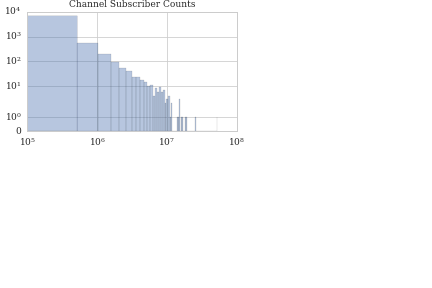

In [6]:
# channel subscriber plot

fig = plt.figure()
ax = sns.distplot(df_channel_stats_first['subscriberCount'], bins=100, kde=False)
ax.set_xlabel('Subscriber')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('symlog')
#ax.legend()

plt.title('Channel Subscriber Counts')
save_plot('channel_subscriber.pdf', fig, s_width, s_height)
#ax.axvline(x=df_channel_stats_first["subscriberCount"].median(), color='red')
#ax.axvline(x=df_channel_stats_first["subscriberCount"].mean(), color='orange')

<IPython.core.display.Javascript object>


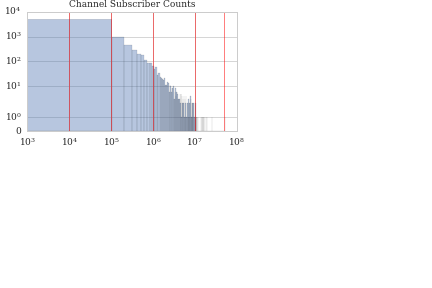

In [7]:
# plotting popularity classes on subscriber range

fig = plt.figure()
ax = sns.distplot(df_channel_stats_first['subscriberCount'], kde=False, bins=500)
ax.set_xlabel('Subscriber')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('symlog')
#ax.legend()
plt.title('Channel Subscriber Counts')

classes = [1.0e+3, 1.0e+4, 1.0e+5, 1.0e+6, 1.0e+7, 5.0e+7, 1.0e+8]
for xc in classes:
    ax.axvline(x=xc, color='red', linewidth=.5)
    
save_plot('channel_subscriber_with_classes.pdf', fig, s_width, s_height)


<IPython.core.display.Javascript object>


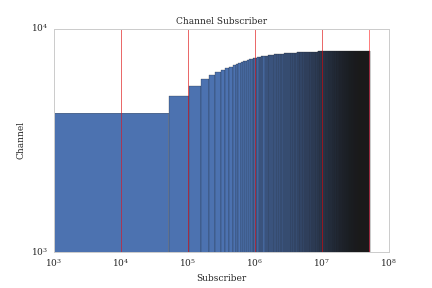

In [8]:
fig = plt.figure()
ax = df_channel_stats_first['subscriberCount'].hist(cumulative=True, bins=1000)
ax.set_xlabel('Subscriber')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.legend()

plt.title('Channel Subscriber')

classes = [1.0e+3, 1.0e+4, 1.0e+5, 1.0e+6, 1.0e+7, 5.0e+7, 1.0e+8]
for xc in classes:
    ax.axvline(x=xc, color='red', linewidth=.5)

In [9]:
bins = [0, 1.0e+3, 1.0e+4, 1.0e+5, 1.0e+6, 1.0e+7, 5.0e+7, 1.0e+8]
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

popularity_classes = []

for i, (a, b) in enumerate(pairwise(bins)):
    #print a, b
    popularity_classes.append((a, b))
    
    
popularity_classes

[(0, 1000.0),
 (1000.0, 10000.0),
 (10000.0, 100000.0),
 (100000.0, 1000000.0),
 (1000000.0, 10000000.0),
 (10000000.0, 50000000.0),
 (50000000.0, 100000000.0)]

[813, 1575, 2569, 2420, 544, 20, 1]
(0-1000.0) 813
(1000.0-10000.0) 1575
(10000.0-100000.0) 2569
(100000.0-1000000.0) 2420
(1000000.0-10000000.0) 544
(10000000.0-50000000.0) 20
(50000000.0-100000000.0) 1


<IPython.core.display.Javascript object>


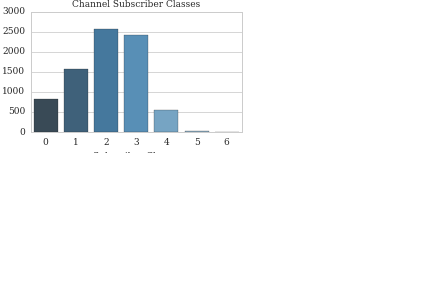

,0
0,813
1,1575
2,2569
3,2420
4,544
5,20
6,1


In [10]:
class_counts = [d.count() for d in [df_channel_stats_first["subscriberCount"][(df_channel_stats_first.subscriberCount >= ca) & (df_channel_stats_first.subscriberCount < cb)] for ca, cb in pairwise(bins)]]

print class_counts

for ca, cb in pairwise(bins):
    print '({}-{}) {}'.format(ca, cb, df_channel_stats_first["subscriberCount"][(df_channel_stats_first.subscriberCount >= ca) & (df_channel_stats_first.subscriberCount < cb)].count())
    
# make barplot with counts and popularity classes named (0..) and legend with ranges
fig = plt.figure()
df_counts = pa.DataFrame(class_counts, index=[range(len(class_counts))])
ax = sns.barplot(x=df_counts.index, y=df_counts[0], palette=sns.color_palette("Blues_d"))
ax.set_xlabel('Subscriber Classes')
ax.set_ylabel('Channel')
#ax.set_yscale('symlog')

plt.title('Channel Subscriber Classes')
save_plot('channel_subscriber_classes_counts.pdf', fig, s_width, s_height)
#[0, 1.0e+3, 1.0e+4, 1.0e+5, 1.0e+6, 1.0e+7, 5.0e+7, 1.0e+8]
#ax.legend(ax.patches, [r'$0: 0-10^3$', r'$1: 10^3-10^4$', r'$0: 0-10^3$', r'$0: 0-10^3$', r'$0: 0-10^3$', r'$0: 0-10^3$', r'$0: 0-10^3$'])
df_counts

<IPython.core.display.Javascript object>


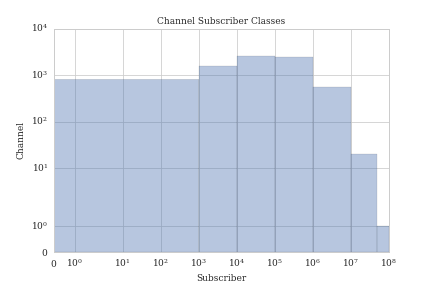

In [11]:
fig = plt.figure()
ax = sns.distplot(df_channel_stats_first['subscriberCount'], kde=False, bins=bins)
ax.set_xlabel('Subscriber')
ax.set_ylabel('Channel')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
#ax.legend()

plt.title('Channel Subscriber Classes')

<IPython.core.display.Javascript object>


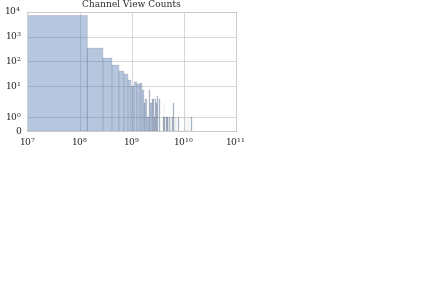

<IPython.core.display.Javascript object>


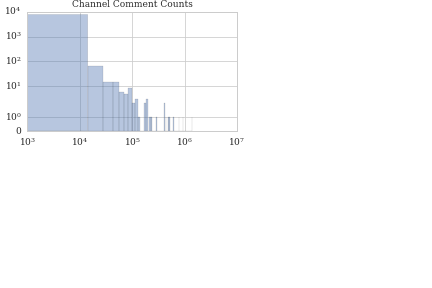

In [12]:
fig = plt.figure()
#sns.distplot(df_channel_stats_first['viewCount'], bins=50, kde=False)

ax = sns.distplot(df_channel_stats_first['viewCount'], kde=False, bins=100)
ax.set_xlabel('Views')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('symlog')
plt.title('Channel View Counts')
save_plot('channel_views.pdf', fig, s_width, s_height)

fig = plt.figure()
ax = sns.distplot(df_channel_stats_first['commentCount'], kde=False, bins=100)
ax.set_xlabel('Comments')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('symlog')
plt.title('Channel Comment Counts')
save_plot('channel_comments.pdf', fig, s_width, s_height)

<IPython.core.display.Javascript object>


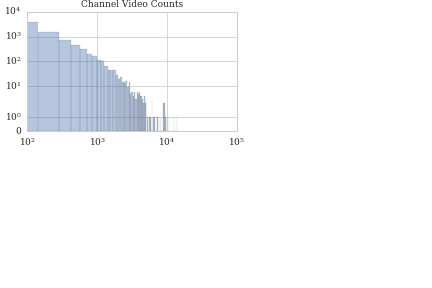

In [13]:
# this are the numbers of videos from the api, ever uploaded or currently
fig = plt.figure()
ax = sns.distplot(df_channel_stats_first['videoCount'], kde=False, bins=100)
ax.set_xlabel('Number of Videos')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('symlog')
#ax.legend()
plt.title('Channel Video Counts')

save_plot('channel_videos.pdf', fig, s_width, s_height)

<IPython.core.display.Javascript object>


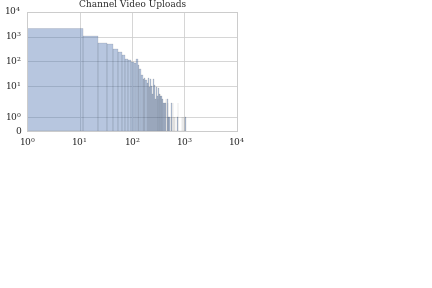

In [14]:
# get numbers of videos actually uploaded in our time-span, in our dataset

with db._session_scope(False) as session:
    uploadsChannelID = pa.read_sql(session.query(Video.channelID).statement, db.engine) 

counts = uploadsChannelID['channelID'].value_counts() 

fig = plt.figure()
ax = sns.distplot(counts, kde=False, bins=100)
ax.set_xlabel('Number of Videos')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('symlog')
#ax.legend()
plt.title('Channel Video Uploads')

save_plot('channel_uploads.pdf', fig, s_width, s_height)

<IPython.core.display.Javascript object>


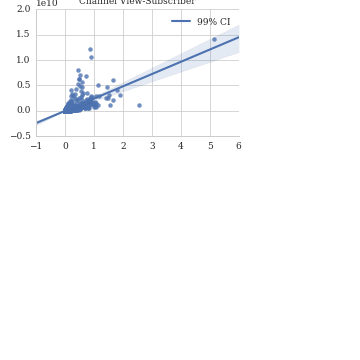

In [15]:
#fig = plt.figure()
ax = sns.lmplot('subscriberCount', 'viewCount', data=df_channel_stats_first, ci=99)
ax.set_xlabels('Subscriber')
ax.set_ylabels('Views')
plt.legend(['99% CI'])
plt.title('Channel View-Subscriber')

save_plot('channel_view_subscriber_reg.pdf', ax.fig, s_width, s_height)

In [16]:
DDIR = '../../data/'

df_channel = pa.read_sql(session.query(Channel).statement, db.engine) 

df_channel = df_channel.set_index('id')

#df_channel[df_channel.network == 'Maker_Studios']['network'] = 'Maker Studios'
df_channel.loc[df_channel['network'] == 'Maker_Studios', 'network'] = 'Maker Studios'


print df_channel['network'].nunique()
print df_channel.loc[df_channel['network'] == 'None', 'network'].count()

df_channel.head()

371
2553


,title,keywords,description,dateAdded,uploadsPlaylistID,latestUploadsIDs,unsubscribedTrailer,topicIds,network,crawlTimestamp,thumbnailUrl
id,,,,,,,,,,,
UC__Pj66OeDibNZNN__L913g,TRACKS - ARTE,"[""ARTE"", ""tracks"", ""culture"", ""musique"", ""unde...",Tracks fait le tour des sons et des cultures q...,2013-11-28T12:52:42.000Z,UU__Pj66OeDibNZNN__L913g,"[""4CLe7teTNJk"",""1EAxOnyRPYA"",""uM1SbbVyVTA"",""Vx...",3znd0FOOqx4,"[""/m/02y26_"",""/m/04rlf""]",None,2016-12-28 02:42:58,https://yt3.ggpht.com/-WLT_WJ83cgk/AAAAAAAAAAI...
UC__PZLSRGtUQiTtvm3hPoEQ,Cripta dos Mistérios,"[""mist\u00e9rios"", ""lendas"", ""fimes"", ""ovnis"",...",Aqui eu falo das coisas que mais gosto MISTÉRI...,2015-06-21T00:43:12.000Z,UU__PZLSRGtUQiTtvm3hPoEQ,"[""qKNTQsgFghs"",""cLZ1W22AIyU"",""VDggyidswBg"",""7-...",UBv-R3OoK2A,"[""/m/02vxn""]",BroadbandTV,2016-12-28 02:42:03,https://yt3.ggpht.com/-7V1tMbgQZ1o/AAAAAAAAAAI...
UC__rmdgxs3ZF0zK_he7Tmig,Contoured Living,[],My name is Laura. I am always searching for th...,2009-09-28T17:21:58.000Z,UU__rmdgxs3ZF0zK_he7Tmig,"[""K9fFvrTUkeU"",""LgldWKMjtWs"",""Hf4rG-Q5r2M"",""bv...",,"[""/m/014trl"",""/m/025t5bz"",""/m/025zp2s"",""/m/027...",None,2016-12-28 02:51:24,https://yt3.ggpht.com/-ceQsyCd1l-4/AAAAAAAAAAI...
UC_-CxgsxX0tpnm24WO-797Q,Mega Gumelar,"[""\""Rachel Goddard\"""", ""\""Tutorial Makeup\"""", ...","Hello Megaliens!\nLet me introduce myself, i a...",2010-02-19T15:28:50.000Z,UU_-CxgsxX0tpnm24WO-797Q,"[""s7fvV2VKsFk"",""Jjj4BV4OGvo"",""J4CIfBp5tgM"",""y7...",0G4UdSvXdyc,"[""/m/014trl"",""/m/0157xl"",""/m/027x0j"",""/m/0wfzt...",Maker Studios,2016-12-28 02:51:51,https://yt3.ggpht.com/-SVZFEnGePB4/AAAAAAAAAAI...
UC_1FUFB6TlGeGOyDI4ikkzg,Best Games For Kids TV,"[""\""Dora Baby Hazel Peppa Pig Bubble Guppies K...","Best Gameplay! Games for Kids, Children TV.\nM...",2013-07-19T12:42:48.000Z,UU_1FUFB6TlGeGOyDI4ikkzg,"[""7PKEvGKtrAY"",""FwU9FoFEZRw"",""15pC_5Dd-1o"",""3s...",fPRU0l-ehmM,"[""/m/0215n"",""/m/02dpv4"",""/m/0ytgt"",""/m/03bt1gh...",BroadbandTV,2016-12-28 02:51:00,https://yt3.ggpht.com/-5pUwQKkReE8/AAAAAAAAAAI...


371 [171  47 171 ..., 164 171  47]


<IPython.core.display.Javascript object>


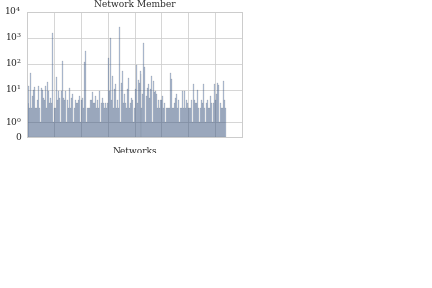

1.0


count     371.000000
mean       21.407008
std       166.776704
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max      2553.000000
Name: Network, dtype: float64

In [17]:
Xuniques, X = np.unique(df_channel['network'], return_inverse=True)

print len(Xuniques), X

dfnn = pa.DataFrame({ 'Network' : np.sort(X)})

fig = plt.figure()
ax = sns.distplot(dfnn, kde=False, bins=200)

ax.set_xlabel('Networks')
ax.set_ylabel('Member')
#ax.set_xscale('log')
ax.set_yscale('symlog')
#ax.legend()
plt.title('Network Member')
ax.set_xticklabels('')
save_plot('network_nof_channel_hist.pdf', fig, s_width, s_height)

counts = dfnn['Network'].value_counts()

print counts.median()
counts.describe()

<IPython.core.display.Javascript object>


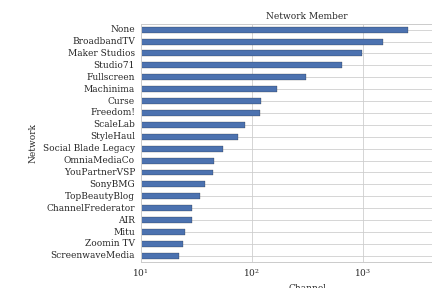

371
None             2553
BroadbandTV      1535
Maker Studios     984
Studio71          658
Fullscreen        309
Name: Network, dtype: int64
20
Index([u'None', u'BroadbandTV', u'Maker Studios', u'Studio71', u'Fullscreen',
       u'Machinima', u'Curse', u'Freedom!', u'ScaleLab', u'StyleHaul',
       u'Social Blade Legacy', u'OmniaMediaCo', u'YouPartnerVSP', u'SonyBMG',
       u'TopBeautyBlog', u'ChannelFrederator', u'AIR', u'Mitu', u'Zoomin TV',
       u'ScreenwaveMedia'],
      dtype='object')


In [18]:
# Channel networks distribution
dfn = pa.DataFrame({ 'Network' : df_channel['network']})
#ax = sns.countplot(x="Network", data=dfn, palette="Greens_d");


fig = plt.figure()
networkcounts = dfn['Network'].value_counts(dropna=False)
print len(networkcounts)
ax = networkcounts[networkcounts > 20.0].sort_values().plot(kind='barh')
networkcounts.to_csv(DIR+'/network_channel_counts.csv')
networks_list = networkcounts[networkcounts > 20.0].index
print networkcounts.head()
print len(networks_list)
print networks_list
ax.set_xlabel('Channel')
ax.set_ylabel('Network')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.legend()

plt.title('Network Member')
fig.tight_layout()
save_plot('network_nof_channel.pdf', fig, x_width, x_height)

<IPython.core.display.Javascript object>


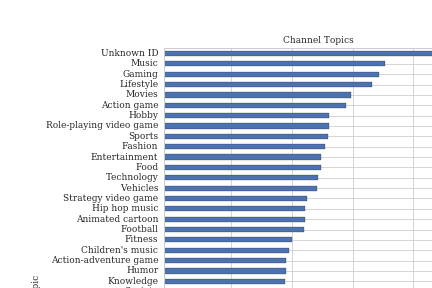

In [19]:
# Channel topics distribution
topics = [x for x in csv.reader(open(DDIR+'topics.txt','r'), delimiter='\t')]

topicIDs = []
topicTitles = {}
for t, tt in topics:
    topicIDs.append(t)
    topicTitles[t]=str(tt).replace('(parent topic)', '')

topicIDs.append('/m/None')    
topicTitles['/m/None'] = 'None'

topicIDs.append('/m/NaT')    
topicTitles['/m/NaT'] = 'Unknown ID'

topiclist = []
for ct in df_channel['topicIds']:
    if len(json.loads(ct))==0:
        topiclist.append('/m/None')
    for t in json.loads(ct):
        if t in topicIDs: # Filter not supported topics (as of 2017, Freebase deprecated)
            topiclist.append(t)
        else:
            topiclist.append('/m/NaT')            
            
            
dft = pa.DataFrame({ 'Topic' : [topicTitles[t] for t in topiclist]})
fig = plt.figure()
ax = dft['Topic'].value_counts().sort_values(ascending=True).plot(kind='barh')

ax.set_xlabel('Channel')
ax.set_ylabel('Topic')
ax.set_xscale('symlog', linthreshx=10)
#ax.set_yscale('log')
#ax.legend()

plt.title('Channel Topics')
fig.tight_layout()
save_plot('channel_topics.pdf', fig, x_width, 2*x_height)

In [21]:
print len(dft[dft.Topic=='None'])
dft['Topic'].value_counts()

50


Unknown ID                 32235
Music                       3402
Gaming                      2733
Lifestyle                   2102
Movies                       927
Action game                  766
Hobby                        413
Role-playing video game      406
Sports                       400
Fashion                      355
Entertainment                307
Food                         297
Technology                   273
Vehicles                     263
Strategy video game          179
Hip hop music                167
Animated cartoon             165
Football                     160
Fitness                      100
Children's music              91
Action-adventure game         81
Humor                         80
Knowledge                     78
Society                       70
TV shows                      68
Sports game                   51
None                          50
Basketball                    43
Pets                          39
Electronic music              39
Performing

In [20]:
categories = [x for x in csv.reader(open(DDIR+'categories.txt','r'), delimiter='\t')]


catIDs = []
catTitles = {}
for t, tt in categories:
    print t, tt
    catIDs.append(int(t))
    catTitles[int(t)]=tt
    
print len(catTitles)

1 Film & Animation
2 Cars & Vehicles
10 Music
15 Pets & Animals
17 Sports
19 Travel & Events
20 Gaming
22 People & Blogs
23 Comedy
24 Entertainment
25 News & Politics
26 How-to & Style
27 Education
28 Science & Technology
29 Non-profits & Activism
15


In [21]:
# Gets all videos from every channel and checks for category most occuring

df_videos = pa.read_sql(session.query(Video).statement, db.engine) 

print len(df_videos['channelID'].unique())

counts = df_videos.groupby(['channelID'])


dfcc = pa.DataFrame(index=df_channel.index, columns = ['category'])

for ch, s in counts.__iter__():
    #print s['category']
    dfcc.ix[ch, 'category'] = catTitles[int(s['category'].value_counts().idxmax())]              
    if len(s) <= 0:
        print ch, s
    #print s['category'].value_counts().max(), s['category'].value_counts().idxmax()

dfcc.ix[dfcc.category.isnull(), 'category'] = 'None'    
    
print len(dfcc[dfcc.category.isnull()] )
dfcc.head()


5891
0


,category
id,
UC__Pj66OeDibNZNN__L913g,Entertainment
UC__PZLSRGtUQiTtvm3hPoEQ,Entertainment
UC__rmdgxs3ZF0zK_he7Tmig,How-to & Style
UC_-CxgsxX0tpnm24WO-797Q,How-to & Style
UC_1FUFB6TlGeGOyDI4ikkzg,Entertainment


In [22]:
print len(dfcc)
print len(dfcc[dfcc.category=='None'])
dfcc.category.value_counts()

7942
2051


None                      2051
Gaming                    1654
Entertainment             1275
People & Blogs             754
Music                      452
How-to & Style             410
Comedy                     405
Film & Animation           297
Education                  191
Science & Technology       171
Sports                     119
Cars & Vehicles             54
News & Politics             35
Travel & Events             31
Pets & Animals              27
Non-profits & Activism      16
Name: category, dtype: int64

<IPython.core.display.Javascript object>


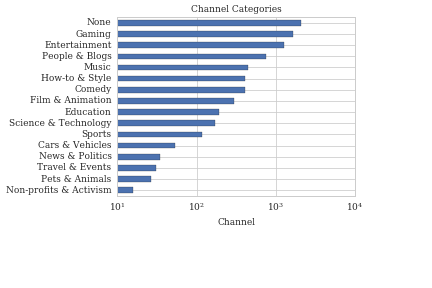

In [23]:
fig = plt.figure()
ax = dfcc['category'].value_counts().sort_values(ascending=True).plot(kind='barh')

ax.set_xlabel('Channel')
ax.set_ylabel('Category')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.legend()

plt.title('Channel Categories')
fig.tight_layout()
save_plot('channel_categories.pdf', fig, 1.5*s_width, 1.5*s_height)

In [24]:
df_test = pa.DataFrame({ 'topicIds' : df_channel['topicIds'].apply(json.loads)})

df_test['network'] = df_channel['network']

df_stats = df_channel_stats_first.set_index('channelID')

df_test[['viewCount', 'subscriberCount', 'videoCount', 'commentCount']] = df_stats[['viewCount', 'subscriberCount', 'videoCount', 'commentCount']]

df_test['category'] = dfcc['category']

def func(x):
    for i, (ca, cb) in enumerate(popularity_classes):
        if x >= ca and x < cb:
            return i

df_test['popularity'] = df_test['subscriberCount'].apply(func)


df_test.head()

#df_test[np.isnan(df_test.popularity)]

#df_test['topicIds'].sort_values()


,topicIds,network,viewCount,subscriberCount,videoCount,commentCount,category,popularity
id,,,,,,,,
UC__Pj66OeDibNZNN__L913g,"[/m/02y26_, /m/04rlf]",None,3253022,23029,967,0,Entertainment,2
UC__PZLSRGtUQiTtvm3hPoEQ,[/m/02vxn],BroadbandTV,310896,5878,144,0,Entertainment,1
UC__rmdgxs3ZF0zK_he7Tmig,"[/m/014trl, /m/025t5bz, /m/025zp2s, /m/027x0j,...",None,1291254,8146,294,121,How-to & Style,1
UC_-CxgsxX0tpnm24WO-797Q,"[/m/014trl, /m/0157xl, /m/027x0j, /m/0wfztg3, ...",Maker Studios,625545,18990,67,101,How-to & Style,2
UC_1FUFB6TlGeGOyDI4ikkzg,"[/m/0215n, /m/02dpv4, /m/0ytgt, /m/03bt1gh, /m...",BroadbandTV,89020205,106760,288,0,Entertainment,3


In [25]:
def func(x):
    topiclist = []
    for t in x:
        if t in topicIDs: # Filter not supported topics (as of 2017, Freebase deprecated)
            topiclist.append(topicTitles[t])
    if len(topiclist)<=0:
        topiclist.append(topicTitles['/m/None'])
    return topiclist

def func2(x):
    topiclist = []
    for t in x:
        if t in topicIDs:
            return topicTitles[t]
    if len(list(x))<=0:
        return topicTitles['/m/None']

    
df_test_copy = df_test.copy()

df_test_copy['topicIds'] = df_test_copy['topicIds'].apply(func)
df_test['topicIds'] = df_test['topicIds'].apply(func2)

print df_test[['topicIds', 'category']].head(10)
print df_test_copy[['topicIds', 'category']].head(10)


                                   topicIds        category
id                                                         
UC__Pj66OeDibNZNN__L913g              Music   Entertainment
UC__PZLSRGtUQiTtvm3hPoEQ             Movies   Entertainment
UC__rmdgxs3ZF0zK_he7Tmig          Lifestyle  How-to & Style
UC_-CxgsxX0tpnm24WO-797Q          Lifestyle  How-to & Style
UC_1FUFB6TlGeGOyDI4ikkzg             Movies   Entertainment
UC_1H9v258pXiyLDaW0R5exw  American football          Sports
UC_1HVMnw-610qx54iEiWk7A             Movies       Education
UC_23cGTZrzuilpX42sHZcnQ        Action game          Gaming
UC_2Fn6J_8D3SvpMrKUAFLOw              Music            None
UC_3gH6zKpk3aCkRkiTik5JA          Lifestyle  People & Blogs
                                                                topicIds  \
id                                                                         
UC__Pj66OeDibNZNN__L913g                                         [Music]   
UC__PZLSRGtUQiTtvm3hPoEQ                            

count    279.000000
mean      27.681004
std       70.105024
min        1.000000
25%        1.500000
50%        5.000000
75%       18.000000
max      573.000000
dtype: float64


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWa

<IPython.core.display.Javascript object>


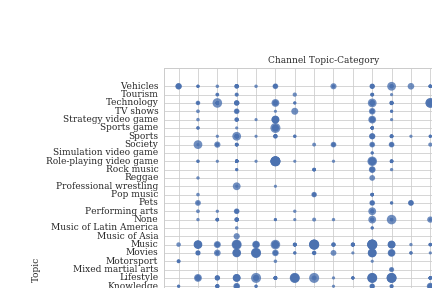

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [26]:
df_test.ix[df_test.category.isnull(), 'category'] = 'None'

groups = df_test.groupby(by=['category', 'topicIds'])
#print df_test.head()
test = groups.size()

print test.describe()

from sklearn.preprocessing import normalize, MinMaxScaler

#area = normalize(test.values[:,np.newaxis], axis=0).ravel()

min_max_scaler = MinMaxScaler(feature_range=(10, 100))
area = min_max_scaler.fit_transform(test.values)


Xuniques, X = np.unique(df_test['category'], return_inverse=True)
Yuniques, Y = np.unique(df_test['topicIds'], return_inverse=True)

fig = plt.figure()

ax = sns.regplot(x=X, y=Y, fit_reg=False, scatter_kws={"s":area})
ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
       yticks=range(len(Yuniques)), yticklabels=Yuniques) 
ax.set_xticklabels(Xuniques, rotation=90, rotation_mode="anchor")
ax.set_xlabel('Category')
ax.set_ylabel('Topic')
ax.tick_params(axis='x', direction='out', pad=52)

leg = [1.0, 250.0, 680.0]
area2 = min_max_scaler.fit_transform(leg)

gll = plt.scatter([],[], s=area2[0], marker='o')
gl = plt.scatter([],[], s=area2[1], marker='o')
ga = plt.scatter([],[], s=area2[2], marker='o')

plt.legend((gll,gl,ga),
       ('1 (min)', '250', '680 (max)'),
       scatterpoints=1,
       loc='upper center', bbox_to_anchor=(-0.15, -0.05),
       ncol=1,
       fontsize=9)

plt.title('Channel Topic-Category')
#fig.tight_layout()
save_plot('channel_topic_category_rel.pdf', fig, x_width, 2.8*x_height)

count     97.000000
mean      71.731959
std      158.997872
min        1.000000
25%        4.000000
50%       13.000000
75%       37.000000
max      739.000000
dtype: float64


/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


<IPython.core.display.Javascript object>


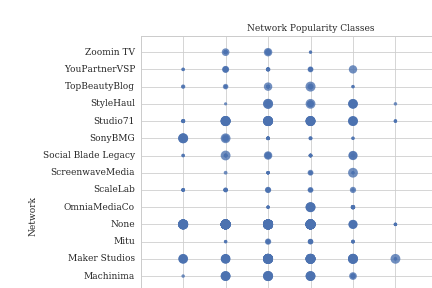

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [27]:
df_test_filtered = df_test[df_test.network.isin(networks_list)]
df_sizes = pa.DataFrame(index=df_test_filtered['network'].unique())

groups = df_test_filtered.groupby(by=['network', 'popularity'])
#print df_test_filtered.head()
test = groups.size()


counts = df_test_filtered['network'].value_counts()


Xuniques, X = np.unique(df_test_filtered['network'], return_inverse=True)
#print pa.DataFrame(X)[0].value_counts()

from sklearn.preprocessing import normalize, MinMaxScaler

print test.describe()

min_max_scaler = MinMaxScaler(feature_range=(10, 100))
area = min_max_scaler.fit_transform(test.values)
#print area

fig = plt.figure()
ax = sns.regplot(y=X, x=df_test_filtered['popularity'], fit_reg=False, scatter_kws={"s":area})
ax.set(yticks=range(len(Xuniques)), yticklabels=Xuniques) 
#ax.set_xticklabels(Xuniques, rotation=45, rotation_mode="anchor")
#ax.tick_params(axis='x', direction='out', pad=52)

leg = [1.0, 300.0, 739.0]
area2 = min_max_scaler.fit_transform(leg)

gll = plt.scatter([],[], s=area2[0], marker='o')
gl = plt.scatter([],[], s=area2[1], marker='o')
ga = plt.scatter([],[], s=area2[2], marker='o')

plt.legend((gll,gl,ga),
       ('1 (min)', '300', '739 (max)'),
       scatterpoints=1,
       loc='upper center', bbox_to_anchor=(-0.15, -0.05),
       ncol=1,
       fontsize=9)

ax.set_xlabel('Popularity Class')
ax.set_ylabel('Network')

plt.title('Network Popularity Classes')
fig.tight_layout()
save_plot('channel_network_classes_rel.pdf', fig, x_width, 1.5*x_height)

97
20
       network  popularity  count
0         None           1    739
1  BroadbandTV           3    708
2         None           2    706
3         None           0    618
4  BroadbandTV           2    504


<IPython.core.display.Javascript object>


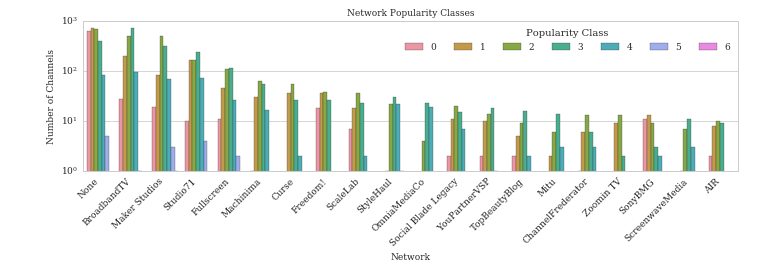

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


In [28]:
df_test_filtered = df_test[df_test.network.isin(networks_list)]
df_sizes = pa.DataFrame(index=df_test_filtered['network'].unique())

groups = df_test_filtered.groupby(by=['network', 'popularity'])

test = groups.size()

test = test.sort_values(ascending=False)
print len(test)
print len(test.index.levels[0])

test2 = test.reset_index()
test2.columns = ['network', 'popularity', 'count']

print test2.head()
# number of channels per network
#counts = df_test_filtered['network'].value_counts()

fig = plt.figure()
#test2.plot(kind='bar')


ax = sns.barplot(x='network', y='count', data=test2, hue='popularity')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")

ax.set_xlabel('Network')
ax.set_ylabel('Number of Channels')
#ax.set_yscale('symlog', linthreshx=10)
ax.set_yscale('log')
l = ax.legend(ncol=len(classes))
l.set_title('Popularity Class')
plt.title('Network Popularity Classes')
fig.tight_layout()

save_plot('channel_network_classes_rel_bar.pdf', fig, 2*x_width, x_height)

In [29]:
df_uniq = df_test.copy()

Xuniques, X = np.unique(df_test['category'], return_inverse=True)
Yuniques, Y = np.unique(df_test['topicIds'], return_inverse=True)
Yuniques, Z = np.unique(df_test['network'], return_inverse=True)

df_uniq['category'] = X
df_uniq['topicIds'] = Y
df_uniq['network'] = Z
  
#fig = plt.figure()
#sns.pairplot(df_uniq)

In [30]:
df_test.head()

,topicIds,network,viewCount,subscriberCount,videoCount,commentCount,category,popularity
id,,,,,,,,
UC__Pj66OeDibNZNN__L913g,Music,None,3253022,23029,967,0,Entertainment,2
UC__PZLSRGtUQiTtvm3hPoEQ,Movies,BroadbandTV,310896,5878,144,0,Entertainment,1
UC__rmdgxs3ZF0zK_he7Tmig,Lifestyle,None,1291254,8146,294,121,How-to & Style,1
UC_-CxgsxX0tpnm24WO-797Q,Lifestyle,Maker Studios,625545,18990,67,101,How-to & Style,2
UC_1FUFB6TlGeGOyDI4ikkzg,Movies,BroadbandTV,89020205,106760,288,0,Entertainment,3


In [31]:
df_test.to_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')


In [32]:
df_test['popularity'].max()

6

In [33]:
# number of cluster per channel -> number of persons per channel (content creator)
# average etc.



In [34]:
with db._session_scope(False) as session:
    #channel_stats_first = session.query(ChannelHistory).filter( (func.day(crawlTimestamp) == 28) & (func.month(crawlTimestamp) == 12) ).all()
    #channel_stats_last = session.query(ChannelHistory).filter( (func.day(crawlTimestamp) == 28) & (func.month(crawlTimestamp) == 2) ).all()

    df_channel_cluster = pa.read_sql(session.query(Video.channelID, VideoFaceCluster.cluster).filter( (VideoFaceCluster.featureID==VideoFeatures.id) & (VideoFeatures.videoID==Video.id)).statement, db.engine)


In [35]:
df_channel_cluster.head()

,channelID,cluster
0,UC--BMyA2X4a9PGAo3lTuopg,9510
1,UC--BMyA2X4a9PGAo3lTuopg,9510
2,UC--BMyA2X4a9PGAo3lTuopg,9510
3,UC--BMyA2X4a9PGAo3lTuopg,12551
4,UC--BMyA2X4a9PGAo3lTuopg,12551
